# Code and visualization for the challenge

In [18]:
#import lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingClassifier ,VotingClassifier
from sklearn.metrics import precision_recall_fscore_support, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn import preprocessing
import missingno as msno 
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.tools as tls 
from plotly.graph_objs import * 

## Loading Data


In [19]:
training_v2 = pd.read_csv("Data/training_v2.csv")
y = training_v2['hospital_death']
X = training_v2.drop('hospital_death',axis = 1)
# remove categorical variables that have too much possible values
X = X.drop(columns = ['encounter_id', 'patient_id', 'hospital_id', 'icu_id','apache_2_diagnosis','apache_3j_diagnosis'])


In [41]:
# description dictionary
descrip_dict = pd.read_csv("Data/WiDS Datathon 2020 Dictionary.csv")
descrip_dict['Variable Name'].to_csv('variables.csv')

/Users/yuyan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.



In [21]:
l, = np.where(descrip_dict['Data Type']== 'integer')
temp = [descrip_dict['Variable Name'].iloc[i] for i in l]
temp

['encounter_id',
 'hospital_id',
 'patient_id',
 'icu_id',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_verbal_apache']

In [22]:
# get categories data
l, = np.where(descrip_dict['Data Type']=='string')
categories = [descrip_dict['Variable Name'].iloc[i] for i in l]
categories = categories[1:len(categories)]
# error in description data
categories.remove('icu_admit_type')
categories.remove('apache_2_diagnosis')
categories.remove('apache_3j_diagnosis')
categories

['ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_stay_type',
 'icu_type',
 'apache_3j_bodysystem',
 'apache_2_bodysystem']

## Missing data Exploration 
Summary of missing data


In [23]:
# get the high and low missing values
# auxillary matrix
aux_mat= pd.isnull(X)
a = aux_mat.sum(axis = 0, skipna = True)
a = a.sort_values()
print("top10 missing variables: ")
# remove non-missing variables
a = a[a!=0]

print( a[0:10])
print("bottom10 missing variables: ")
print( a[len(a)-31:len(a)-1])
cutting_thres = 0.5
high_miss_list = a[a>aux_mat.shape[0]*cutting_thres].index
print(high_miss_list)


top10 missing variables: 
gender               25
icu_admit_source    112
d1_heartrate_max    145
d1_heartrate_min    145
d1_sysbp_min        159
d1_sysbp_max        159
d1_diasbp_max       165
d1_diasbp_min       165
d1_mbp_min          220
d1_mbp_max          220
dtype: int64
bottom10 missing variables: 
h1_mbp_invasive_max       74844
h1_sysbp_invasive_max     74915
h1_sysbp_invasive_min     74915
h1_diasbp_invasive_max    74928
h1_diasbp_invasive_min    74928
h1_creatinine_min         74957
h1_creatinine_max         74957
h1_bun_max                75091
h1_bun_min                75091
h1_platelets_min          75673
h1_platelets_max          75673
h1_calcium_min            75863
h1_calcium_max            75863
h1_arterial_po2_max       75945
h1_arterial_po2_min       75945
h1_wbc_min                75953
h1_wbc_max                75953
h1_arterial_pco2_max      75959
h1_arterial_pco2_min      75959
h1_hco3_max               76094
h1_hco3_min               76094
h1_arterial_ph_min  

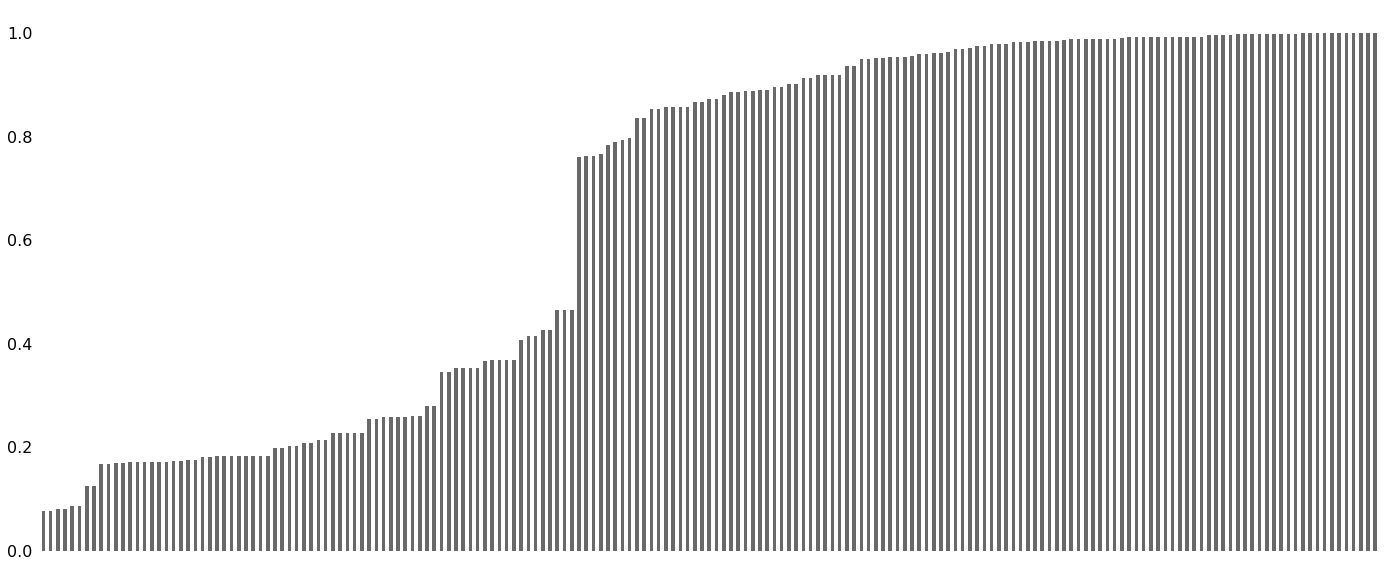

In [13]:
# missing data distribution
msno.bar(X, sort = 'ascending') 

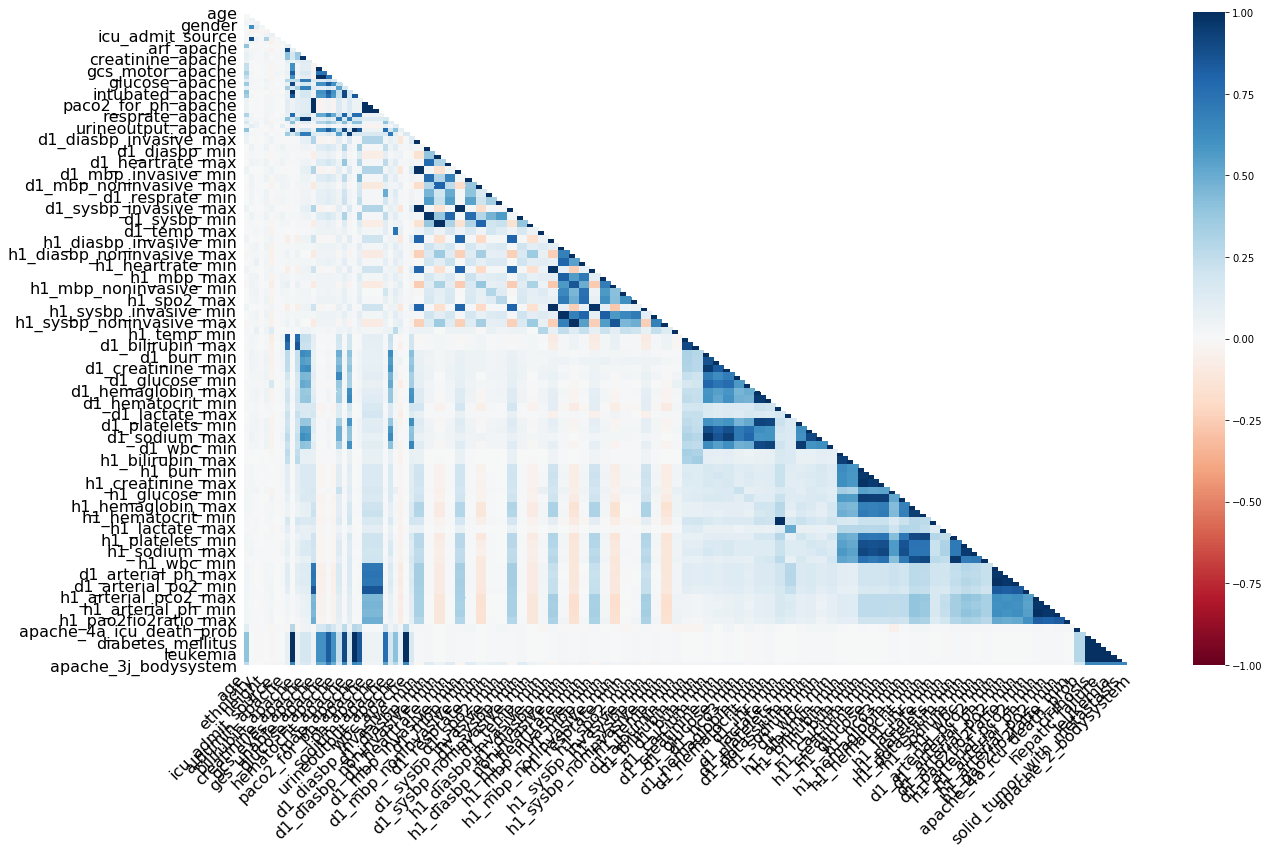

In [21]:
# heatmap
msno.heatmap(X, labels=False)

In [7]:
# Association between missingness and death rate
p_miss = aux_mat.sum(axis = 1, skipna = True)
print(p_miss.sort_values())
print(scipy.stats.pointbiserialr(y, p_miss))

12850      0
8286       0
10228      0
42849      0
41618      0
        ... 
13063    156
12563    156
90275    158
33104    166
3011     167
Length: 91713, dtype: int64
PointbiserialrResult(correlation=-0.1225517660874609, pvalue=9.211407356565366e-304)


In [8]:
d = {}
for col in aux_mat.columns:
    d[col] = matthews_corrcoef(y, aux_mat[col])
dd = pd.Series(d)

/Users/yuyan/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning:

invalid value encountered in double_scalars



In [11]:
dd = dd.sort_values()
print(dd[0:10])
print(dd[169:179])

d1_arterial_po2_min    -0.200287
d1_arterial_po2_max    -0.200287
d1_arterial_pco2_max   -0.200038
d1_arterial_pco2_min   -0.200038
d1_arterial_ph_max     -0.196743
d1_arterial_ph_min     -0.196743
d1_pao2fio2ratio_min   -0.191633
d1_pao2fio2ratio_max   -0.191633
d1_lactate_max         -0.179123
d1_lactate_min         -0.179123
dtype: float64
h1_diasbp_invasive_min    0.018133
height                    0.024283
d1_temp_min               0.029015
d1_temp_max               0.029015
urineoutput_apache        0.037316
temp_apache               0.038383
gcs_motor_apache          0.044953
gcs_eyes_apache           0.044953
gcs_verbal_apache         0.044953
age                       0.051312
dtype: float64


In [38]:
dd = pd.DataFrame.from_dict(d)

## Missing data imputation

Find the best missing data imputation method
1. simple imputation
2. replace with indicator
3. KNN imputation

### simple imputation

In [24]:
# simple imputation
categorical = pd.get_dummies(X[categories], dummy_na=True)
continuous = X.drop(columns=categories)

imp = SimpleImputer(strategy = 'mean')
new_data = pd.DataFrame(imp.fit_transform(continuous))
new_data.columns = continuous.columns

new_X = new_data
#new_X = pd.concat([new_data, categorical], axis=1, sort=False)

#print("X",X.shape)
pd.isnull(new_X).sum().sum()

0

In [25]:
high_aux_mat = aux_mat.drop(columns = aux_mat.columns.difference(high_miss_list))
high_aux_mat.columns = ["I_" + s for s in high_aux_mat.columns]
high_aux_mat.columns

Index(['I_albumin_apache', 'I_bilirubin_apache', 'I_fio2_apache',
       'I_paco2_apache', 'I_paco2_for_ph_apache', 'I_pao2_apache',
       'I_ph_apache', 'I_urineoutput_apache', 'I_d1_diasbp_invasive_max',
       'I_d1_diasbp_invasive_min', 'I_d1_mbp_invasive_max',
       'I_d1_mbp_invasive_min', 'I_d1_sysbp_invasive_max',
       'I_d1_sysbp_invasive_min', 'I_h1_diasbp_invasive_max',
       'I_h1_diasbp_invasive_min', 'I_h1_mbp_invasive_max',
       'I_h1_mbp_invasive_min', 'I_h1_sysbp_invasive_max',
       'I_h1_sysbp_invasive_min', 'I_d1_albumin_max', 'I_d1_albumin_min',
       'I_d1_bilirubin_max', 'I_d1_bilirubin_min', 'I_d1_inr_max',
       'I_d1_inr_min', 'I_d1_lactate_max', 'I_d1_lactate_min',
       'I_h1_albumin_max', 'I_h1_albumin_min', 'I_h1_bilirubin_max',
       'I_h1_bilirubin_min', 'I_h1_bun_max', 'I_h1_bun_min',
       'I_h1_calcium_max', 'I_h1_calcium_min', 'I_h1_creatinine_max',
       'I_h1_creatinine_min', 'I_h1_glucose_max', 'I_h1_glucose_min',
       'I_h1_hco3_m

In [26]:
X_train, X_test ,y_train, y_test = train_test_split(new_X, y, test_size=0.2, random_state=1)


In [27]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 19)]
learning_rate = [x for x in np.linspace(start = 0.01, stop = 1, num = 19)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 20, num = 19)]
max_depth.append(None)
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)
best_random = rf_random.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed: 48.4min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 48.6min finished


{'n_estimators': 105, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}


In [28]:
predictions = best_random.predict(X_test)
#print(precision_recall_fscore_support(y_test, predictions, average='binary'))
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
metrics.auc(fpr, tpr)

0.8853941774411161

In [29]:
predictions = best_random.predict(X_train)
#print(precision_recall_fscore_support(y_train, predictions, average='binary'))
fpr, tpr, thresholds = metrics.roc_curve(y_train, predictions, pos_label=1)
metrics.auc(fpr, tpr)

0.9275421952378311

In [8]:
# simple imputation
categorical = pd.get_dummies(X[categories], dummy_na=True)
continuous = X.drop(columns=categories)

imp = SimpleImputer(strategy = 'most_frequent')
new_data = pd.DataFrame(imp.fit_transform(continuous))
new_data.columns = continuous.columns

new_X = new_data
#new_X = pd.concat([new_data, categorical], axis=1, sort=False)

#print("X",X.shape)
pd.isnull(new_X).sum().sum()

0

In [9]:
high_aux_mat = aux_mat.drop(columns = aux_mat.columns.difference(high_miss_list))
high_aux_mat.columns = ["I_" + s for s in high_aux_mat.columns]
high_aux_mat.columns

Index(['I_albumin_apache', 'I_bilirubin_apache', 'I_fio2_apache',
       'I_paco2_apache', 'I_paco2_for_ph_apache', 'I_pao2_apache',
       'I_ph_apache', 'I_urineoutput_apache', 'I_d1_diasbp_invasive_max',
       'I_d1_diasbp_invasive_min', 'I_d1_mbp_invasive_max',
       'I_d1_mbp_invasive_min', 'I_d1_sysbp_invasive_max',
       'I_d1_sysbp_invasive_min', 'I_h1_diasbp_invasive_max',
       'I_h1_diasbp_invasive_min', 'I_h1_mbp_invasive_max',
       'I_h1_mbp_invasive_min', 'I_h1_sysbp_invasive_max',
       'I_h1_sysbp_invasive_min', 'I_d1_albumin_max', 'I_d1_albumin_min',
       'I_d1_bilirubin_max', 'I_d1_bilirubin_min', 'I_d1_inr_max',
       'I_d1_inr_min', 'I_d1_lactate_max', 'I_d1_lactate_min',
       'I_h1_albumin_max', 'I_h1_albumin_min', 'I_h1_bilirubin_max',
       'I_h1_bilirubin_min', 'I_h1_bun_max', 'I_h1_bun_min',
       'I_h1_calcium_max', 'I_h1_calcium_min', 'I_h1_creatinine_max',
       'I_h1_creatinine_min', 'I_h1_glucose_max', 'I_h1_glucose_min',
       'I_h1_hco3_m

In [10]:
X_train, X_test ,y_train, y_test = train_test_split(new_X, y, test_size=0.2, random_state=1)


In [11]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 19)]
learning_rate = [x for x in np.linspace(start = 0.01, stop = 1, num = 19)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 20, num = 19)]
max_depth.append(None)
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)
best_random = rf_random.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed: 17.1min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 17.2min finished


{'n_estimators': 105, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}


In [12]:
predictions = best_random.predict(X_test)
#print(precision_recall_fscore_support(y_test, predictions, average='binary'))
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
metrics.auc(fpr, tpr)

0.883090035575931

In [13]:
predictions = best_random.predict(X_train)
#print(precision_recall_fscore_support(y_train, predictions, average='binary'))
fpr, tpr, thresholds = metrics.roc_curve(y_train, predictions, pos_label=1)
metrics.auc(fpr, tpr)

0.9244067320328199

### missing indicators

In [89]:
new_X = aux_mat
pd.isnull(new_X).sum().sum()
X_train, X_test ,y_train, y_test = train_test_split(new_X, y, test_size=0.2, random_state=1)


In [93]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 19)]
learning_rate = [x for x in np.linspace(start = 0.01, stop = 1, num = 19)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 20, num = 19)]
max_depth.append(None)
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 5, verbose=2, random_state=2)#
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)
best_random = rf_random.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] n_estimators=157, max_features=auto, max_depth=12, bootstrap=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=157, max_features=auto, max_depth=12, bootstrap=False, total= 1.4min
[CV] n_estimators=157, max_features=auto, max_depth=12, bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s


[CV]  n_estimators=157, max_features=auto, max_depth=12, bootstrap=False, total= 1.4min
[CV] n_estimators=157, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=157, max_features=auto, max_depth=12, bootstrap=False, total= 1.4min
[CV] n_estimators=157, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=157, max_features=auto, max_depth=12, bootstrap=False, total= 1.4min
[CV] n_estimators=157, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=157, max_features=auto, max_depth=12, bootstrap=False, total= 1.5min
[CV] n_estimators=157, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=157, max_features=sqrt, max_depth=14, bootstrap=True, total=   8.6s
[CV] n_estimators=157, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=157, max_features=sqrt, max_depth=14, bootstrap=True, total=   8.5s
[CV] n_estimators=157, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=157, max_features=sq

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 12.9min finished


{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 13, 'bootstrap': True}


In [94]:
predictions = best_random.predict(X_test)
#print(precision_recall_fscore_support(y_test, predictions, average='binary'))
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
metrics.auc(fpr, tpr)

0.7817200582335161

In [95]:
predictions = best_random.predict(X_train)
#print(precision_recall_fscore_support(y_train, predictions, average='binary'))
fpr, tpr, thresholds = metrics.roc_curve(y_train, predictions, pos_label=1)
metrics.auc(fpr, tpr)

0.8370099976929171

In [14]:
# only for high list
high_aux_mat = aux_mat.drop(columns = aux_mat.columns.difference(high_miss_list))
new_X = high_aux_mat
pd.isnull(new_X).sum().sum()
X_train, X_test ,y_train, y_test = train_test_split(new_X, y, test_size=0.2, random_state=1)


In [15]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 19)]
learning_rate = [x for x in np.linspace(start = 0.01, stop = 1, num = 19)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 20, num = 19)]
max_depth.append(None)
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 5, verbose=2, random_state=2)#
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)
best_random = rf_random.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] n_estimators=157, max_features=auto, max_depth=12, bootstrap=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=157, max_features=auto, max_depth=12, bootstrap=False, total=  29.3s
[CV] n_estimators=157, max_features=auto, max_depth=12, bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.3s remaining:    0.0s


[CV]  n_estimators=157, max_features=auto, max_depth=12, bootstrap=False, total=  29.5s
[CV] n_estimators=157, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=157, max_features=auto, max_depth=12, bootstrap=False, total=  33.3s
[CV] n_estimators=157, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=157, max_features=auto, max_depth=12, bootstrap=False, total=  28.6s
[CV] n_estimators=157, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=157, max_features=auto, max_depth=12, bootstrap=False, total=  29.1s
[CV] n_estimators=157, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=157, max_features=sqrt, max_depth=14, bootstrap=True, total=   4.5s
[CV] n_estimators=157, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=157, max_features=sqrt, max_depth=14, bootstrap=True, total=   4.5s
[CV] n_estimators=157, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=157, max_features=sq

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  5.0min finished


{'n_estimators': 157, 'max_features': 'sqrt', 'max_depth': 8, 'bootstrap': True}


In [16]:
predictions = best_random.predict(X_test)
#print(precision_recall_fscore_support(y_test, predictions, average='binary'))
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
metrics.auc(fpr, tpr)

0.7649436334893122

In [17]:
predictions = best_random.predict(X_train)
#print(precision_recall_fscore_support(y_train, predictions, average='binary'))
fpr, tpr, thresholds = metrics.roc_curve(y_train, predictions, pos_label=1)
metrics.auc(fpr, tpr)

0.7651425473016675

Using only high missing variables still got a fairly good auc and has small bias.

### KNNimputer

In [30]:
new_X = pd.read_csv('Data/knnimpute.csv')
#new_X = pd.concat([new_data, categorical], axis=1, sort=False)

#print("X",X.shape)
pd.isnull(new_X).sum().sum()

0

In [31]:
X_train, X_test ,y_train, y_test = train_test_split(new_X, y, test_size=0.2, random_state=1)


In [32]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 19)]
learning_rate = [x for x in np.linspace(start = 0.01, stop = 1, num = 19)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 20, num = 19)]
max_depth.append(None)
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)
best_random = rf_random.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed: 41.8min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 42.2min finished


{'n_estimators': 105, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}


In [33]:
predictions = best_random.predict(X_test)
#print(precision_recall_fscore_support(y_train, predictions, average='binary'))
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
metrics.auc(fpr, tpr)

0.8839563253116792

In [34]:
predictions = best_random.predict(X_train)
#print(precision_recall_fscore_support(y_train, predictions, average='binary'))
fpr, tpr, thresholds = metrics.roc_curve(y_train, predictions, pos_label=1)
metrics.auc(fpr, tpr)

0.9316433729095213

## Feature importance

In [ ]:
# select the best imputer and combine with high indicators


In [36]:
# simple imputation
categorical = pd.get_dummies(X[categories], dummy_na=True)
continuous = X.drop(columns=categories)

imp = SimpleImputer(strategy = 'mean')
new_data = pd.DataFrame(imp.fit_transform(continuous))
new_data.columns = continuous.columns

high_aux_mat = aux_mat.drop(columns = aux_mat.columns.difference(high_miss_list))
high_aux_mat.columns = ["I_" + s for s in high_aux_mat.columns]

new_X = pd.concat([new_data, categorical, high_aux_mat], axis=1, sort=False)

#print("X",X.shape)
pd.isnull(new_X).sum().sum()

0

In [82]:
# get the high and low missing values
# auxillary matrix
aux_mat= pd.isnull(continuous)
a = aux_mat.sum(axis = 0, skipna = True)
a = a.sort_values()
print("top10 missing variables: ")
# remove non-missing variables
a = a[a!=0]
print( a[0:10])
print("bottom10 missing variables: ")
print( a[len(a)-11:len(a)-1])
cutting_thres = 0.5
high_miss_list = a[a>aux_mat.shape[0]*cutting_thres].index
print(high_miss_list)

top10 missing variables: 
d1_heartrate_max    145
d1_heartrate_min    145
d1_sysbp_max        159
d1_sysbp_min        159
d1_diasbp_max       165
d1_diasbp_min       165
d1_mbp_min          220
d1_mbp_max          220
d1_spo2_max         333
d1_spo2_min         333
dtype: int64
bottom10 missing variables: 
h1_hco3_min             76094
h1_arterial_ph_min      76424
h1_arterial_ph_max      76424
h1_pao2fio2ratio_max    80195
h1_pao2fio2ratio_min    80195
h1_albumin_min          83824
h1_albumin_max          83824
h1_lactate_max          84369
h1_lactate_min          84369
h1_bilirubin_min        84619
dtype: int64
Index(['urineoutput_apache', 'd1_albumin_max', 'd1_albumin_min',
       'h1_glucose_min', 'h1_glucose_max', 'd1_bilirubin_max',
       'd1_bilirubin_min', 'albumin_apache', 'h1_inr_max', 'h1_inr_min',
       'd1_inr_max', 'd1_inr_min', 'bilirubin_apache', 'd1_arterial_po2_max',
       'd1_arterial_po2_min', 'd1_arterial_pco2_max', 'd1_arterial_pco2_min',
       'd1_arterial_ph

In [37]:
X_train, X_test ,y_train, y_test = train_test_split(new_X, y, test_size=0.2, random_state=1)


### Random forest

In [84]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 19)]
learning_rate = [x for x in np.linspace(start = 0.01, stop = 1, num = 19)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 20, num = 19)]
max_depth.append(None)
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)
best_random = rf_random.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed: 49.0min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 49.2min finished


{'n_estimators': 105, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}


In [85]:
predictions = best_random.predict(X_test)
#print(precision_recall_fscore_support(y_test, predictions, average='binary'))
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
metrics.auc(fpr, tpr)

0.8859220841418517

In [86]:
predictions = best_random.predict(X_train)
#print(precision_recall_fscore_support(y_train, predictions, average='binary'))
fpr, tpr, thresholds = metrics.roc_curve(y_train, predictions, pos_label=1)
metrics.auc(fpr, tpr)

0.9297800238836051

In [87]:
importances = best_random.feature_importances_
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, importances):
    feats[feature] = importance #add the name/value pair 
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'importance'})

importances = importances.sort_values(by='importance',ascending= False)
importances[0:15]

,importance
apache_4a_icu_death_prob,0.124882
apache_4a_hospital_death_prob,0.098725
d1_lactate_min,0.049879
d1_lactate_max,0.031210
d1_sysbp_min,0.029045
gcs_motor_apache,0.026301
d1_arterial_ph_min,0.022069
d1_temp_min,0.019710
d1_spo2_min,0.019645
d1_sysbp_noninvasive_min,0.019248


In [112]:
high_aux_mat.columns
non_high = [i[2:len(i)] for i in high_aux_mat.columns]
high_i = [X_train.columns.get_loc(i) for i in high_aux_mat.columns]
non_high_i = [X_train.columns.get_loc(i) for i in non_high]
high_f = best_random.feature_importances_[high_i]
non_high_f =  best_random.feature_importances_[non_high_i]
diff = high_f - non_high_f
np.mean(diff)

-0.002717490071351314

### LASSO

### Logistic regression


In [108]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
predictions = clf.predict(X_test)
print(precision_recall_fscore_support(y_test, predictions, average='binary'))
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
metrics.auc(fpr, tpr)

/Users/yuyan/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



(0.6201232032854209, 0.18910457107075768, 0.28982725527831094, None)


0.5890285783814316

In [109]:
predictions = clf.predict(X_train)
print(precision_recall_fscore_support(y_train, predictions, average='binary'))
fpr, tpr, thresholds = metrics.roc_curve(y_train, predictions, pos_label=1)
metrics.auc(fpr, tpr)

(0.6258992805755396, 0.17901234567901234, 0.2784, None)


0.5844653090323118

In [110]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, co_ef in zip(X_train.columns, clf.coef_[0]):
    feats[feature] = co_ef 

co_efs = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'co_ef'})
co_efs = co_efs.sort_values(by='co_ef',ascending= False)


In [111]:
high_aux_mat.columns
non_high = [i[2:len(i)] for i in high_aux_mat.columns]
high_i = [X_train.columns.get_loc(i) for i in high_aux_mat.columns]
non_high_i = [X_train.columns.get_loc(i) for i in non_high]
high_f = np.array([float(i) for i in clf.coef_[0][high_i]])
non_high_f = np.array([float(i) for i in clf.coef_[0][non_high_i]])
diff = high_f - non_high_f
np.mean(diff)

-0.0009058737415662931

### Boosting methods
Yu

In [35]:
GBC = GradientBoostingClassifier(random_state = 1)
GBC.fit(X_train, y_train)
predictions = GBC.predict(X_test)
print(precision_recall_fscore_support(y_test, predictions, average='binary'))
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
metrics.auc(fpr, tpr)

(0.6963064295485636, 0.3187226048841578, 0.43728522336769765, None)


0.6527328538573423

In [114]:
votingC = VotingClassifier(estimators=[('rfc', rf),('gbc',GBC)], voting='soft')
votingC = votingC.fit(X_train, y_train)
predictions = votingC.predict(X_test)
print(precision_recall_fscore_support(y_test, predictions, average='binary'))
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
metrics.auc(fpr, tpr)

ValueError: The estimator RandomForestRegressor should be a classifier.

### Adaboost

In [115]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print(precision_recall_fscore_support(y_test, predictions, average='binary'))
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
metrics.auc(fpr, tpr)

(0.6350710900473934, 0.33562930494677523, 0.4391642769356821, None)


0.6586184265089783

In [116]:
predictions = clf.predict(X_train)
print(precision_recall_fscore_support(y_train, predictions, average='binary'))
fpr, tpr, thresholds = metrics.roc_curve(y_train, predictions, pos_label=1)
metrics.auc(fpr, tpr)

(0.673469387755102, 0.34472934472934474, 0.4560301507537688, None)


0.6644901868907118

### XGBoost

In [117]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier, XGBRegressor
'''
def modelfit(alg, X_train, y_train,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train)#, label=X_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)#, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_train, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

    
    
#predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, X_train,y_train)
'''
from sklearn.datasets import dump_svmlight_file
dump_svmlight_file(X_train,y_train, "X.train")
dump_svmlight_file(X_test,y_test, "X.test")
'''
Xlearning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic')
XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)'''
model = XGBRegressor(n_estimators = 25, max_depth = 5)
model.fit(X_train, y_train)
prob = model.predict(X_test)
predictions = prob
#print(precision_recall_fscore_support(y_test, predictions, average='binary'))
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
metrics.auc(fpr, tpr)

0.881936029583715

In [118]:
prob = model.predict(X_train)
predictions = prob
#print(precision_recall_fscore_support(y_test, predictions, average='binary'))
fpr, tpr, thresholds = metrics.roc_curve(y_train, predictions, pos_label=1)
metrics.auc(fpr, tpr)

0.9171459890135114

### Neural Net

In [119]:
from sklearn.neural_network import MLPClassifier

In [120]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(73370, 313)
(73370,)
(18343, 313)
(18343,)


In [121]:
clf = MLPClassifier(solver='sgd', activation='relu',alpha=1e-4,hidden_layer_sizes=(142,142,), random_state=1, max_iter = 500)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print(predictions)
print(precision_recall_fscore_support(y_test, predictions, average='binary'))
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
metrics.auc(fpr, tpr)


[0 0 0 ... 0 0 0]
(0.0, 0.0, 0.0, None)


/Users/yuyan/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



0.5

In [122]:
predictions = clf.predict(X_train)
print(precision_recall_fscore_support(y_train, predictions, average='binary'))
fpr, tpr, thresholds = metrics.roc_curve(y_train, predictions, pos_label=1)
metrics.auc(fpr, tpr)

(0.0, 0.0, 0.0, None)


/Users/yuyan/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



0.5

In [123]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

/Users/yuyan/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/Users/yuyan/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/Users/yuyan/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/Users/yuyan/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be unders

In [124]:
model = Sequential()
#variables = X_train_test.shape[1]
model.add(Dense(132, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(132, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(132, activation='relu'))
model.add(Dense(132, activation='relu'))
model.add(Dense(132, activation='relu'))

#model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# define optimizer
opt = tf.keras.optimizers.Adam(0.01)

# compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'binary_crossentropy'])#tf.keras.metrics.AUC()])


# fit the model

model.fit(X_train, y_train, epochs=500, batch_size=500, verbose=0)#, class_weight = class_weights)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [125]:
predictions = model.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
metrics.auc(fpr, tpr)

0.5001339397791498

In [126]:
predictions = model.predict(X_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train, predictions, pos_label=1)
metrics.auc(fpr, tpr)

0.5000716820689047